In [1]:
!python3 -m pip install -r requirements.txt

     |████████████████████████████████| 133kB 11.2MB/s 
     |████████████████████████████████| 10.3MB 14.2MB/s 
     |████████████████████████████████| 153kB 41.5MB/s 
     |████████████████████████████████| 19.3MB 1.3MB/s 
     |████████████████████████████████| 409kB 38.4MB/s 
     |████████████████████████████████| 11.7MB 25.4MB/s 
     |████████████████████████████████| 2.0MB 30.7MB/s 
ERROR: Could not find a version that satisfies the requirement dataclasses==0.8 (from -r requirements.txt (line 52)) (from versions: 0.1, 0.2, 0.3, 0.4, 0.5, 0.6)
ERROR: No matching distribution found for dataclasses==0.8 (from -r requirements.txt (line 52))


In [2]:
import os
import torch
import torchvision
import tarfile
import torchvision.transforms as tt

from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder

In [3]:
# Загрузим набор данных 
url = "https://s3.amazonaws.com/fast-ai-imageclas/imagewoof-160.tgz"
download_url(url, '.')
# Извлечение набора данных 
with tarfile.open('./imagewoof-160.tgz', 'r:gz') as tar: #read file in r mode
    tar.extractall(path = './data') #extract all folders from zip file and store under folder named data

# Подготовка набора данных 

In [4]:
data_dir = './data/imagewoof-160'
print(os.listdir('./data/imagewoof-160/train'))
print(len(os.listdir('./data/imagewoof-160/train')))

['n02111889', 'n02115641', 'n02099601', 'n02105641', 'n02086240', 'n02093754', 'n02089973', 'n02096294', 'n02088364', 'n02087394']
10


Название классов для понятного соответствия взято отсюда 

In [5]:
classes = [
    'Australian terrier', 
    'Border terrier', 
    'Samoyed', 
    'Beagle', 
    'Shih-Tzu', 
    'English foxhound', 
    'Rhodesian ridgeback', 
    'Dingo', 
    'Golden retriever', 
    'Old English sheepdog'
]

количество экземпляров в тренировочном и тестовом наборах 

In [6]:
train_dir = './data/imagewoof-160/train/'
test_dir = './data/imagewoof-160/val/'

train_numbers = [len(_f) for _r, _d, _f in os.walk(train_dir)]
print(f"Train set all:{sum(train_numbers)}")  

test_numbers = [len(_f) for _r, _d, _f in os.walk(test_dir)]
print(f"Test set all:{sum(test_numbers)}")  

Train set all:12454
Test set all:500


# Баланс классов

In [7]:
print(train_numbers[1:])
print(test_numbers[1:])

[1300, 1300, 1300, 1300, 1300, 1300, 754, 1300, 1300, 1300]
[50, 50, 50, 50, 50, 50, 50, 50, 50, 50]


In [ ]:
# Объявление ImageFolder 
# класс хранит информацию о расположении набора данных на диске 
# и при загрузке преобразует в тензор 
verify_set = ImageFolder(train_dir, tt.ToTensor())

In [ ]:
# Найдём минимальный и максимальный размер изображений 
height = []
width = []
for image,_s in verify_set:
    height.append(image.shape[1])
    width.append(image.shape[2])
print("minimum height: {}, maximum height: {}, minimum width: {}, maximum width: {}".format(min(height), max(height), min(width), max(width)))
# Размер изображений не одинаков, нужно это исправить 

minimum height: 160, maximum height: 391, minimum width: 160, maximum width: 615


In [8]:
# IMAGENET mean and std values for normalization 
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

# Создадим набор преобразований над изображением перед подачей экземпляра на обучение 
train_transform = tt.Compose([
    tt.RandomCrop(160, padding=1, padding_mode='reflect'), 
    tt.RandomHorizontalFlip(),
    tt.RandomRotation(degrees=15),
    tt.ToTensor(),
    tt.Normalize(*stats,inplace=True)]
)

# Тестовый набор не будем переворачивать 
test_transform = tt.Compose([
    tt.RandomResizedCrop(160),
    tt.ToTensor(), 
    tt.Normalize(*stats)
])

In [9]:
# Объявление ImageFolder 
# класс хранит информацию о расположении набора данных на диске 
# и при загрузке преобразует в тензор и выполняет другие преобразования над изображением
train_full_ds = ImageFolder(data_dir + '/train', train_transform)
test_ds = ImageFolder(data_dir + '/val', test_transform)

In [10]:
# Проверим минимальный и максимальный размер изображений с учётом всех преобразований 

height = []
width = []
for image,_s in train_full_ds:
    height.append(image.shape[1])
    width.append(image.shape[2])
print("minimum height: {}, maximum height: {}, minimum width: {}, maximum width: {}".format(min(height), max(height), min(width), max(width)))
# Размер изображений одинаков.

minimum height: 160, maximum height: 160, minimum width: 160, maximum width: 160


Визуально убедимся что всё работает как надо 

In [11]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
def show_example(img, label):
    print('Порода: ', classes[label], '('+str(label)+')')
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Порода:  Australian terrier (0)


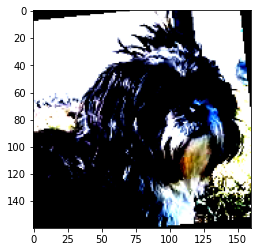

In [13]:
show_example(*train_full_ds[0])

На картинке собака похожая на терьера

### Training and Validation Datasets

In [14]:
from torch.utils.data.dataloader import DataLoader
random_seed = 43
# размер батча 
batch_size = 32
torch.manual_seed(random_seed)

# Установим размер валидационной и тренировочной выборок
validation_size = 1000
train_size = len(train_full_ds) - validation_size

# Разделим наборы данных 
train_ds, val_ds = random_split(train_full_ds, [train_size, validation_size])
len(train_ds), len(val_ds)

train_dl = DataLoader(
    # dataset 
    train_ds, 
    batch_size, 
    shuffle = True, 
    num_workers= 4, 
    pin_memory=True
)

val_dl = DataLoader(
    val_ds, 
    batch_size * 2, 
    num_workers=4, 
    pin_memory=True
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Взглянем на один батч для обучения 

In [15]:
from torchvision.utils import make_grid

def denormalize(images, means, stds):
    """Восстанавливаем исходное изображение """
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1,)
    return images * stds + means


def show_batch(dl, denorm=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize = (15,15))
        ax.set_xticks([]), ax.set_yticks([])
        if denorm:
            images = denormalize(images, *stats)
        ax.imshow(make_grid(images[:64],nrow = 8).permute(1,2,0).clamp(0,1))
        break


В таком виде изображения подаются на обучение 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


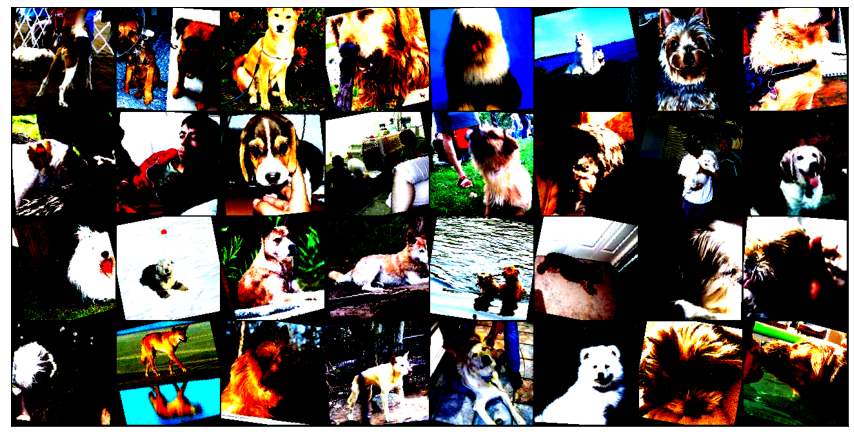

In [16]:
show_batch(train_dl, denorm=False)

Исходная палитра 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


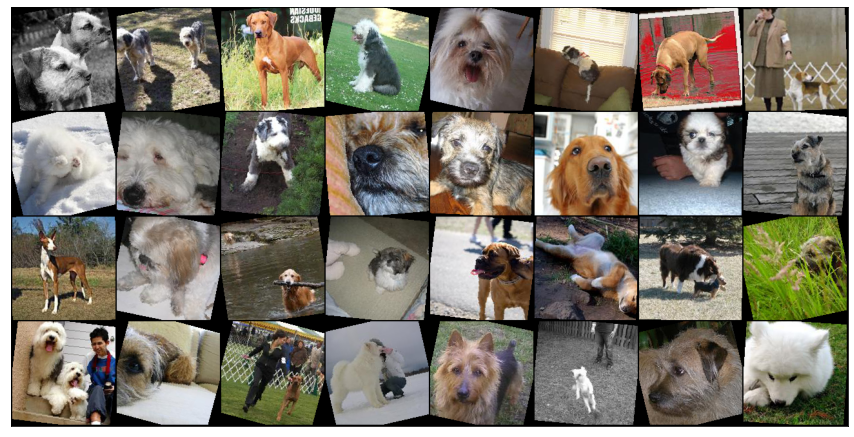

In [17]:
show_batch(train_dl, denorm=True)

In [20]:
import torch.nn as nn
import torch.nn.functional as F

In [21]:
class ImageClassificationBase(nn.Module):
    # Шаг обучения 
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        # Для справки https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    # Шаг потери 
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    # Вывод результатов на конец эпохи обучения 
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [22]:
class WoofClassifier(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4, 4), # output: 64 x 40 x 40

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 1024 x 20 x 20

            nn.Conv2d(1024, 2048, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(2048, 2048, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4, 4), # output: 1024 x 5 x 5

            nn.Flatten(), 
            nn.Linear(2048 * 5 * 5, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [23]:
# Выведем конфигурацию модели
model = WoofClassifier()
model

WoofClassifier(
  (network): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(2048, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=51200, out_features=2048, bias=True)
    (17): ReLU()
    (18): Linea

In [24]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [25]:
# Получение платформы на которой будет производится обучение CPU or GPU 
device = get_default_device()
device

device(type='cuda')

In [26]:
# Здесь уже конкретный класс загрузки для платформы, так как у CPU и GPU разные платформы
# По сути тот же dataloader объявленный выше
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
# to_device(model, device)


In [27]:
# декоратор производящий проход по сети для инференса бзе изменений градиента 
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# @torch.no_grad()
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [28]:
model = to_device(WoofClassifier(), device)

In [30]:
%%time
num_epochs = 8
opt_func = torch.optim.Adam
lr = 0.0001

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1], train_loss: 1.9476, val_loss: 1.9070, val_acc: 0.2984
Epoch [2], train_loss: 1.8420, val_loss: 1.8068, val_acc: 0.3609
Epoch [3], train_loss: 1.7300, val_loss: 1.7304, val_acc: 0.3418
Epoch [4], train_loss: 1.5897, val_loss: 1.6026, val_acc: 0.4172
Epoch [5], train_loss: 1.4408, val_loss: 1.4099, val_acc: 0.4977
Epoch [6], train_loss: 1.2872, val_loss: 1.3261, val_acc: 0.5312
Epoch [7], train_loss: 1.1696, val_loss: 1.2203, val_acc: 0.5748
Epoch [8], train_loss: 1.0716, val_loss: 1.2072, val_acc: 0.5875
CPU times: user 34min 30s, sys: 34min 33s, total: 1h 9min 3s
Wall time: 1h 9min 4s


In [31]:
%%time
history += fit(6, 0.0000001, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1], train_loss: 1.0138, val_loss: 1.1353, val_acc: 0.6105
Epoch [2], train_loss: 0.9630, val_loss: 1.1364, val_acc: 0.6076
Epoch [3], train_loss: 0.9276, val_loss: 1.0995, val_acc: 0.6215
Epoch [4], train_loss: 0.9040, val_loss: 1.0724, val_acc: 0.6326
Epoch [5], train_loss: 0.8925, val_loss: 1.0936, val_acc: 0.6281
Epoch [6], train_loss: 0.8827, val_loss: 1.0684, val_acc: 0.6320
CPU times: user 25min 44s, sys: 25min 35s, total: 51min 20s
Wall time: 51min 27s


### Loss and Accuracy 

In [1]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel(['accuracy'])
    plt.title('Accuracy vs No. of epoch')


In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training','Validation'])
    plt.title('Loss vs No. of epoch')

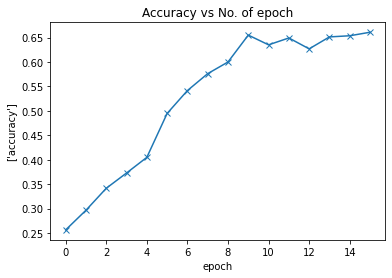

In [ ]:
plot_accuracies(history)

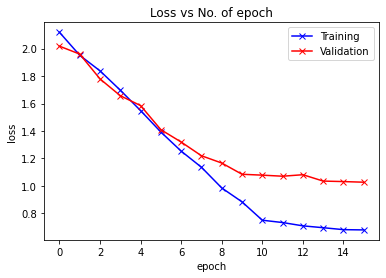

In [ ]:
plot_losses(history)

In [1]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0),device)
    yb = model(xb)
    _, preds = torch.max(yb, dim = 1)
    return classes[preds[0].item()]

In [2]:
img, label = test_ds[0]
plt.imshow(img.permute(1,2,0))
print("Исходный:", classes[label], ', Предсказанный:', predict_image(img,model))

NameError: ignored

In [3]:
img, label = test_ds[250]
plt.imshow(img.permute(1,2,0))
print("Исходный:", classes[label], ', Предсказанный:', predict_image(img,model))

NameError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Golden retriever , Predicted: Golden retriever


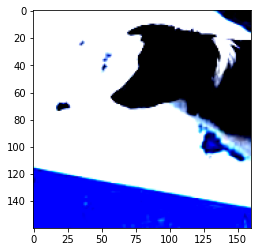

In [ ]:
img, label = test_ds[400]
plt.imshow(img.permute(1,2,0))
print("Исходный:", classes[label], ', Предсказанный:', predict_image(img,model))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_ds, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.46612340211868286, 'val_loss': 1.6142189502716064}

### Сохранение и повторное использование модели

In [ ]:
torch.save(model.state_dict(), 'imagewoof-1.pth')
model2 = to_device(Imagewoof(), device)
model2.load_state_dict(torch.load('imagewoof-1.pth'))
evaluate(model2, test_loader)